# Section 1. Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

In [1]:
# Hide warning to make the notebook clear.
import warnings
#warnings.filterwarnings('ignore')

#### Import libraries and setup matplotlib

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from data_utils import TextMelLoader
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

In [3]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [4]:
hparams = create_hparams()
hparams.sampling_rate = 22050

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



#### Load model from checkpoint

In [5]:
#checkpoint_path = "tacotron2_statedict.pt"
#checkpoint_path = "outdir/checkpoint_24000"
prj_name = 'MulSpkEngEmoTTS'
run_name = 'ljspeech'
checkpoint_path = "outdir/{}/{}/checkpoint_608-epoch_0.9984_end-epoch_0".format(prj_name, run_name)
#checkpoint_path = '/home/sungjaecho/pretrained/tacotron2_statedict.pt'
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [6]:
#waveglow_path = 'waveglow_256channels.pt'
waveglow_path = '/data2/sungjaecho/pretrained/waveglow_256channels_ljs_v2.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

#### Prepare text input

In [7]:
#text = "Waveglow is really awesome!"
text = "KAIST is a research institute."
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Prepare speaker input

In [8]:
train_set = TextMelLoader(hparams, 'train')

In [9]:
print(train_set.speaker_list)
print(train_set.emotion_list)

['emovdb-m-josh', 'emovdb-m-sam', 'emovdb-w-bea', 'emovdb-w-jenie', 'ljs-w']
['amused', 'angry', 'disgusted', 'neutral', 'sleepy']


In [10]:
str_speaker = 'ljs-w'
str_emotion = 'neutral'
speaker_index = train_set.get_speaker(str_speaker).long().cuda()
emotion_vector = train_set.get_emotion(str_emotion).half().cuda().view(1,-1)
print(speaker_index)
print(speaker_index.type())
print(emotion_vector)
print(emotion_vector.type())

tensor([4], device='cuda:0')
torch.cuda.LongTensor
tensor([[0., 0., 0., 0.]], device='cuda:0', dtype=torch.float16)
torch.cuda.HalfTensor


#### Decode text input and plot results

In [11]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence, speaker_index, emotion_vector)

speaker_embeddings.size() torch.Size([1, 6])
emotion_embeddings.size() torch.Size([1, 3])
Warning! Reached max decoder steps


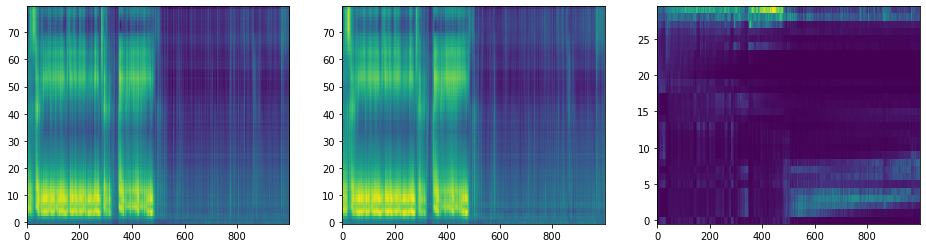

In [12]:
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [13]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [14]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 